In [59]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [116]:
class KNN():
    def __init__(self, points, values, k=3):
        """
        points : tensor-like with shape (N, D), as the reference points in D-dim
        values : tensor-like with shape (N,), as the values at reference points
        k      : int, as the number of the nearest neighbors
        
        The algorithm is the same as the one in straxen https://github.com/XENONnT/straxen/blob/a8402c46053105ad5c60b38ae91ef9b8a1571aa7/straxen/itp_map.py#L15.
        """
        self.ref_points = tf.convert_to_tensor(points, dtype=tf.float32)
        self.ref_values = tf.convert_to_tensor(values, dtype=tf.float32)
        self.k = k
        self.num_ref, self.dim = tf.shape(points)
        
        assert self.num_ref > self.k, "Number of reference points must be larger than k!"
        assert self.num_ref == len(self.ref_values), "Shape of points %s is inconsistent with shape of values %s!"%(self.ref_points.shape, self.ref_values.shape)
        
    def __call__(self, *args, **kwargs):
        return self.interp(*args, **kwargs)
        
    def L2_dist2(self, pop1, pop2):
        """
        pop1 : tensor-like with shape (N, D)
        pop2 : tensor-like with shape (M, D)
        
        return : L2 distance squared with shape (N, M)
        """
        dr = tf.expand_dims(pop1, axis=1) - tf.expand_dims(pop2, axis=0)
        return tf.reduce_sum(tf.square(dr), axis=-1)
        
    def interp(self, points):
        """
        points : tensor-like with shape (N, D), as the points to be interpolated.
        """
        points = tf.convert_to_tensor(points, dtype=tf.float32)
        
        dr2 = - self.L2_dist2(points, self.ref_points) # (num_pts, num_ref)
        dr2, ind = tf.math.top_k(dr2, self.k) # (num_pts, k)
        weights = 1.0 / tf.clip_by_value(tf.sqrt(-dr2), 1e-6, float('inf')) # (num_pts, k)
        vals = tf.gather(self.ref_values, ind) # (num_pts, k)
        vals = tf.math.reduce_sum(vals * weights, axis=1) / tf.math.reduce_sum(weights, axis=1)  # (num_pts, )
        return vals

In [117]:
def f(x, y):
    return np.sin(2*x) * np.cos(0.5*y)

In [118]:
xx = np.random.uniform(-5, 5, int(1e3))
yy = np.random.uniform(-5, 5, int(1e3))

points = np.transpose(np.array([xx, yy]))
values = f(xx, yy)

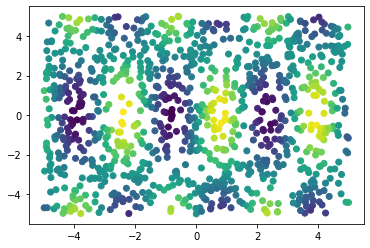

In [119]:
plt.scatter(points[:, 0], points[:, 1], c=values)

In [120]:
itpf = KNN(points, values, k=3)

In [121]:
x = np.random.uniform(-5, 5, int(1e4))
y = np.random.uniform(-5, 5, int(1e4))

pts = np.transpose(np.array([x, y]))
vals = itpf(pts)

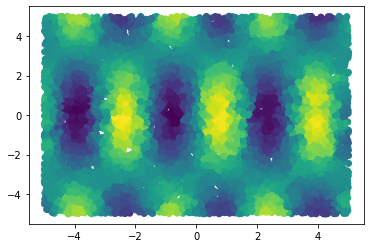

In [122]:
plt.scatter(pts[:, 0], pts[:, 1], c=vals)